# Face

<h4>Import Required Libraries</h4>

In [1]:
# Step 1: Import required libraries
import os
import glob
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import joblib
import pickle

import torch
import torch.nn as nn
from torchvision import models, transforms
from transformers import ViTModel, ViTFeatureExtractor

<h4>Loading Image Paths And Labels</h4>

In [2]:
# Step 2: Load image paths and labels
def load_image_paths_and_labels(root_dir):
    image_paths, labels = [], []
    for person_folder in sorted(os.listdir(root_dir)):
        person_path = os.path.join(root_dir, person_folder)
        if os.path.isdir(person_path):
            images = glob.glob(os.path.join(person_path, '*.jpg'))  # or .png
            image_paths.extend(images)
            labels.extend([person_folder] * len(images))
    return image_paths, labels

<h4>Applying models CNN And Vision Transformers</h4>

In [3]:
# Step 3: CNN and ViT setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cnn_model = models.resnet50(pretrained=True)
cnn_model = nn.Sequential(*list(cnn_model.children())[:-1])
cnn_model.to(device).eval()

cnn_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model.to(device).eval()
vit_feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

C:\Users\rames\anaconda3\envs\Biometrics\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\rames\anaconda3\envs\Biometrics\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\rames\anaconda3\envs\Biometrics\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


<h4>Extracting Features Functions</h4>

In [4]:
# Step 4: Feature Extraction Functions
def extract_cnn_features(image):
    img_tensor = cnn_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = cnn_model(img_tensor).squeeze().cpu().numpy()
    return features

def extract_vit_features(image):
    inputs = vit_feature_extractor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = vit_model(**inputs)
        features = outputs.pooler_output.squeeze().cpu().numpy()
    return features

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None
    image = cv2.cvtColor(cv2.resize(image, (224, 224)), cv2.COLOR_BGR2RGB)
    try:
        cnn_feat = extract_cnn_features(image)
        vit_feat = extract_vit_features(image)
        combined = np.concatenate((cnn_feat, vit_feat))  # 2048 + 768 = 2816
        return combined
    except Exception as e:
        print(f"Error in feature extraction for {image_path}: {e}")
        return None

<h4>Data Preprocessing</h4>

In [5]:
# Step 5: Dataset preprocessing
def preprocess_dataset(image_paths, labels):
    X, y = [], []
    for path, label in tqdm(zip(image_paths, labels), total=len(image_paths), desc="Preprocessing"):
        features = preprocess_image(path)
        if features is not None:
            X.append(features)
            y.append(label)
    return X, y

<h4>Dataset Path Setup</h4>

In [6]:
# Step 6: Paths setup
base_path = r"C:\Users\rames\OneDrive\Desktop\Biometrics\data\face"

train_images, train_labels = load_image_paths_and_labels(os.path.join(base_path, 'Train'))
test_images, test_labels = load_image_paths_and_labels(os.path.join(base_path, 'Test'))
val_images, val_labels = load_image_paths_and_labels(os.path.join(base_path, 'Validation'))

<h4>Preprocessing Datasets</h4>

In [7]:
# Step 7: Preprocess datasets
print("Preprocessing train images...")
X_train, y_train = preprocess_dataset(train_images, train_labels)

print("Preprocessing test images...")
X_test, y_test = preprocess_dataset(test_images, test_labels)

print("Preprocessing validation images...")
X_val, y_val = preprocess_dataset(val_images, val_labels)

Preprocessing train images...


Preprocessing: 100%|███████████████████████████████████████████████████████████████| 3010/3010 [56:55<00:00,  1.13s/it]


Preprocessing test images...


Preprocessing: 100%|█████████████████████████████████████████████████████████████████| 645/645 [13:33<00:00,  1.26s/it]


Preprocessing validation images...


Preprocessing: 100%|█████████████████████████████████████████████████████████████████| 645/645 [49:50<00:00,  4.64s/it]


<h4>Encoding Labels</h4>

In [8]:
# Step 8: Encode labels
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)
y_val_enc = encoder.transform(y_val)

<h4>Training Random Forest classifier</h4>

In [9]:
# Step 9: Train Random Forest classifier
print("Training Random Forest classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train_enc)

Training Random Forest classifier...


RandomForestClassifier(random_state=42)

<h4>Evaluation, Saving model and Saving Features</h4>


Random Forest Evaluation on Validation Set:
              precision    recall  f1-score   support

      Aparna       1.00      1.00      1.00        15
     Sanjana       1.00      1.00      1.00        15
   Sreenidhi       1.00      1.00      1.00        15
     person1       1.00      0.93      0.97        15
    person10       1.00      1.00      1.00        15
    person11       1.00      1.00      1.00        15
    person12       0.94      1.00      0.97        15
    person13       0.94      1.00      0.97        15
    person14       0.94      1.00      0.97        15
    person15       0.94      1.00      0.97        15
    person16       1.00      1.00      1.00        15
    person17       0.94      1.00      0.97        15
    person18       0.94      1.00      0.97        15
    person19       1.00      0.87      0.93        15
     person2       0.88      1.00      0.94        15
    person20       1.00      1.00      1.00        15
    person21       1.00      1.00   

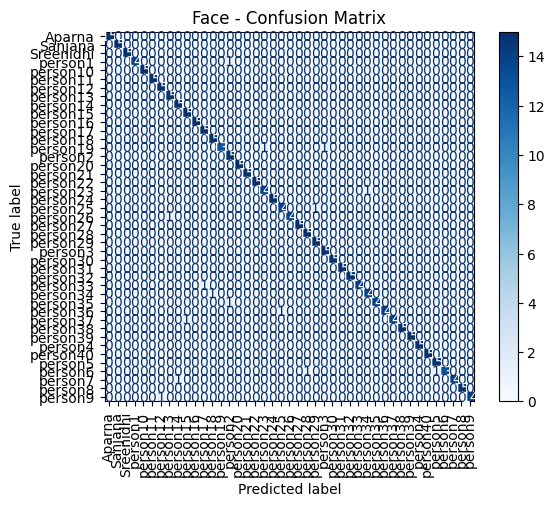

Model saved to random_forest_face_model.pkl
Features and labels saved to face_features_and_labels.pkl


In [10]:
# Step 10: Evaluate
print("\nRandom Forest Evaluation on Validation Set:")
pred_rf = rf_model.predict(X_val)
print(classification_report(y_val_enc, pred_rf, target_names=encoder.classes_))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion matrix for Face
cm_face = confusion_matrix(y_val_enc, pred_rf)
disp_face = ConfusionMatrixDisplay(confusion_matrix=cm_face, display_labels=encoder.classes_)
disp_face.plot(cmap='Blues', xticks_rotation=90)
plt.title("Face - Confusion Matrix")
plt.show()
# Step 11: Save the model
model_path = "random_forest_face_model.pkl"
joblib.dump(rf_model, model_path)
print(f"Model saved to {model_path}")

# Step 12: Save feature arrays and labels
feature_data = {
    "X_train": X_train,
    "y_train": y_train_enc,
    "X_test": X_test,
    "y_test": y_test_enc,
    "X_val": X_val,
    "y_val": y_val_enc,
    "label_encoder": encoder
}

features_path = "face_features_and_labels.pkl"
with open(features_path, 'wb') as f:
    pickle.dump(feature_data, f)

print(f"Features and labels saved to {features_path}")


<h4> Face Performance</h4> 

C:\Users\rames\AppData\Local\Temp\ipykernel_33156\1428275569.py:34: UserWarning: Glyph 128311 (\N{LARGE BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rames\anaconda3\envs\Biometrics\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128311 (\N{LARGE BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


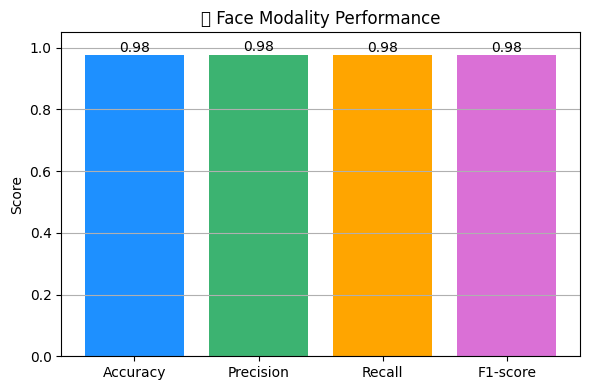

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

# === FACE ===
y_face_true = face_data["y_val"]
y_face_pred = face_model.predict(face_data["X_val"])
face_report = classification_report(y_face_true, y_face_pred, output_dict=True)
face_accuracy = accuracy_score(y_face_true, y_face_pred)

# Collect metrics
metrics_face = {
    "Accuracy": face_accuracy,
    "Precision": face_report["weighted avg"]["precision"],
    "Recall": face_report["weighted avg"]["recall"],
    "F1-score": face_report["weighted avg"]["f1-score"]
}

# Colors for bars
colors = ["dodgerblue", "mediumseagreen", "orange", "orchid"]

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(metrics_face.keys(), metrics_face.values(), color=colors)
plt.ylim(0.0, 1.05)
plt.title("🔷 Face Modality Performance")
plt.ylabel("Score")
plt.grid(True, axis='y')

# Add labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.2f}", ha='center')

plt.tight_layout()
plt.show()


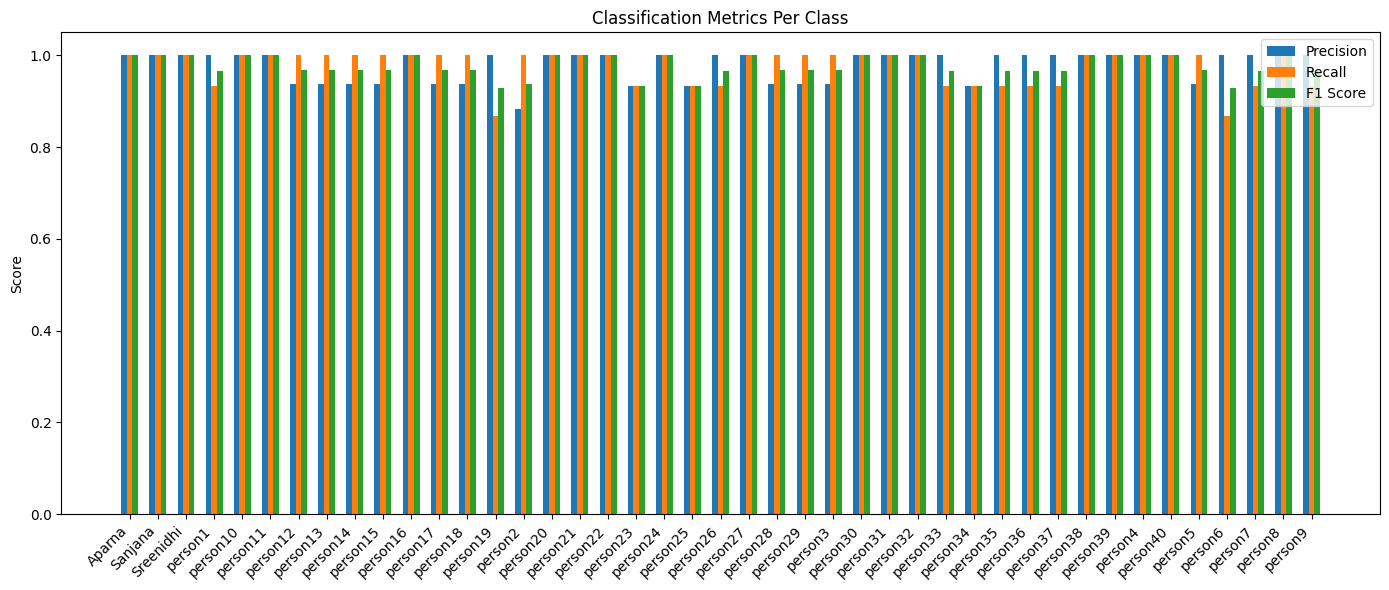

In [11]:
from sklearn.metrics import classification_report

# Get classification report as a dict
report_dict = classification_report(y_val_enc, pred_rf, target_names=encoder.classes_, output_dict=True)

# Extract metrics per class
classes = list(encoder.classes_)
precision = [report_dict[cls]['precision'] for cls in classes]
recall = [report_dict[cls]['recall'] for cls in classes]
f1_score = [report_dict[cls]['f1-score'] for cls in classes]
accuracy = [report_dict[cls]['f1-score'] for cls in classes]  # f1 as per-class performance proxy

# Plotting the metrics
x = np.arange(len(classes))  # class indices
width = 0.2  # width of the bars

plt.figure(figsize=(14, 6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1_score, width, label='F1 Score')

plt.xticks(x, classes, rotation=45, ha='right')
plt.ylabel('Score')
plt.title('Classification Metrics Per Class')
plt.legend()
plt.tight_layout()
plt.show()


# IRIS

<h4>Import Required Libraries</h4>

In [12]:
# Step 1: Import required libraries
import os
import glob
import cv2
import numpy as np
import pywt
import pickle
import joblib
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import torch
from transformers import ViTModel, ViTFeatureExtractor

<h4>Loading Image Paths And Labels</h4>

In [13]:
# Step 2: Load image paths and labels
def load_image_paths_and_labels(root_dir):
    image_paths, labels = [], []
    for person_folder in sorted(os.listdir(root_dir)):
        person_path = os.path.join(root_dir, person_folder)
        if os.path.isdir(person_path):
            images = glob.glob(os.path.join(person_path, '*.jpg'))  # or .png
            image_paths.extend(images)
            labels.extend([person_folder] * len(images))
    return image_paths, labels

<h4>Applying Model WTN (Wavelet Transform) </h4>

In [14]:
# Step 3: Wavelet Transform (WTN)
def wavelet_transform(image):
    coeffs = pywt.wavedec2(image, 'haar', level=2)
    flattened_coeffs = []
    for coeff_level in coeffs:
        if isinstance(coeff_level, tuple):
            for arr in coeff_level:
                flattened_coeffs.extend(arr.flatten())
        else:
            flattened_coeffs.extend(coeff_level.flatten())
    return np.array(flattened_coeffs[:4096])  # fixed size

<h4>Applying Model Vit (Vision Transformer)</h4>

In [15]:
# Step 4: Vision Transformer Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k').to(device).eval()
vit_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

C:\Users\rames\anaconda3\envs\Biometrics\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


<h4>Combining Models (WTN + ViT)</h4>

In [16]:
# Step 5: Combined Feature Extraction (WTN + ViT)
def extract_features(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None

    try:
        image_resized = cv2.resize(image, (224, 224))

        # WTN on grayscale
        gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
        wavelet_feat = wavelet_transform(gray)

        # ViT on RGB
        inputs = vit_extractor(images=image_resized, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = vit_model(**inputs)
        vit_feat = outputs.pooler_output.squeeze().cpu().numpy()

        combined = np.concatenate((wavelet_feat, vit_feat))  # 4096 + 768 = 4864
        return combined
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

<h4>Preprocessing Dataset</h4>

In [17]:
# Step 6: Preprocess dataset
def preprocess_dataset(image_paths, labels):
    X, y = [], []
    for path, label in tqdm(zip(image_paths, labels), total=len(image_paths), desc="Extracting WTN + ViT Features"):
        features = extract_features(path)
        if features is not None:
            X.append(features)
            y.append(label)
    return X, y

<h4>Loading Dataset</h4>

In [18]:
# Step 7: Load data
base_path = r"C:\Users\rames\OneDrive\Desktop\Biometrics\data\iris"
train_images, train_labels = load_image_paths_and_labels(os.path.join(base_path, 'Train'))
test_images, test_labels = load_image_paths_and_labels(os.path.join(base_path, 'Test'))
val_images, val_labels = load_image_paths_and_labels(os.path.join(base_path, 'Validation'))

print("Preprocessing training data...")
X_train, y_train = preprocess_dataset(train_images, train_labels)

print("Preprocessing test data...")
X_test, y_test = preprocess_dataset(test_images, test_labels)

print("Preprocessing validation data...")
X_val, y_val = preprocess_dataset(val_images, val_labels)

Preprocessing training data...


Extracting WTN + ViT Features: 100%|███████████████████████████████████████████████| 3010/3010 [59:37<00:00,  1.19s/it]


Preprocessing test data...


Extracting WTN + ViT Features: 100%|█████████████████████████████████████████████████| 645/645 [13:15<00:00,  1.23s/it]


Preprocessing validation data...


Extracting WTN + ViT Features: 100%|███████████████████████████████████████████████| 645/645 [6:18:14<00:00, 35.19s/it]


<h4>Encoding Labels</h4>

In [19]:
# Step 8: Encode labels
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)
y_val_enc = encoder.transform(y_val)

<h4>Training Random Forest Model</h4>

In [20]:
# Step 9: Train Random Forest model
print("Training Random Forest classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train_enc)

Training Random Forest classifier...


RandomForestClassifier(random_state=42)

<h4>Evaluation , Saving model and Saving Features</h4>


Random Forest Evaluation on Validation Set:
              precision    recall  f1-score   support

      Aparna       0.88      1.00      0.94        15
     Sanjana       1.00      1.00      1.00        15
   Sreenidhi       1.00      1.00      1.00        15
     person1       0.83      1.00      0.91        15
    person10       1.00      0.93      0.97        15
    person11       0.87      0.87      0.87        15
    person12       0.81      0.87      0.84        15
    person13       1.00      1.00      1.00        15
    person14       0.93      0.93      0.93        15
    person15       0.88      0.93      0.90        15
    person16       0.82      0.93      0.88        15
    person17       0.93      0.93      0.93        15
    person18       1.00      0.80      0.89        15
    person19       0.93      0.87      0.90        15
     person2       0.82      0.93      0.88        15
    person20       0.75      0.80      0.77        15
    person21       1.00      1.00   

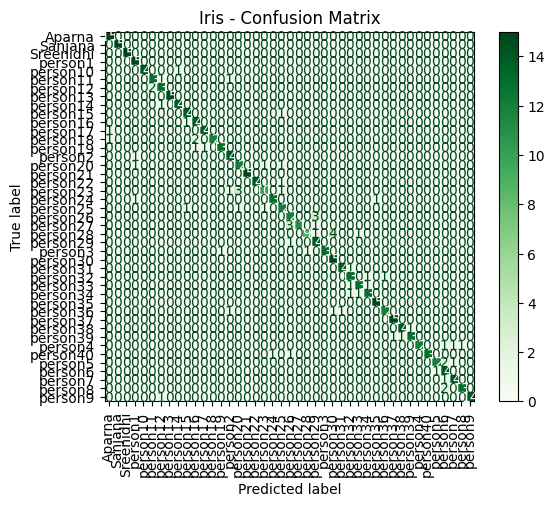

Model saved to rf_iris_model_wtn_vit.pkl
Features and labels saved to iris_features_wtn_vit.pkl


In [21]:
# Step 10: Evaluate
print("\nRandom Forest Evaluation on Validation Set:")
pred_val = rf_model.predict(X_val)
print(classification_report(y_val_enc, pred_val, target_names=encoder.classes_))
# Confusion matrix for Iris
cm_iris = confusion_matrix(y_val_enc, pred_val)
disp_iris = ConfusionMatrixDisplay(confusion_matrix=cm_iris, display_labels=encoder.classes_)
disp_iris.plot(cmap='Greens', xticks_rotation=90)
plt.title("Iris - Confusion Matrix")
plt.show()
# Step 11: Save model
model_path = "rf_iris_model_wtn_vit.pkl"
joblib.dump(rf_model, model_path)
print(f"Model saved to {model_path}")

# Step 12: Save feature arrays
feature_data = {
    "X_train": X_train,
    "y_train": y_train_enc,
    "X_test": X_test,
    "y_test": y_test_enc,
    "X_val": X_val,
    "y_val": y_val_enc,
    "label_encoder": encoder
}

features_path = "iris_features_wtn_vit.pkl"
with open(features_path, 'wb') as f:
    pickle.dump(feature_data, f)

print(f"Features and labels saved to {features_path}")


<h4>IRIS Performance</h4>

C:\Users\rames\AppData\Local\Temp\ipykernel_33156\4251757236.py:27: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rames\anaconda3\envs\Biometrics\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


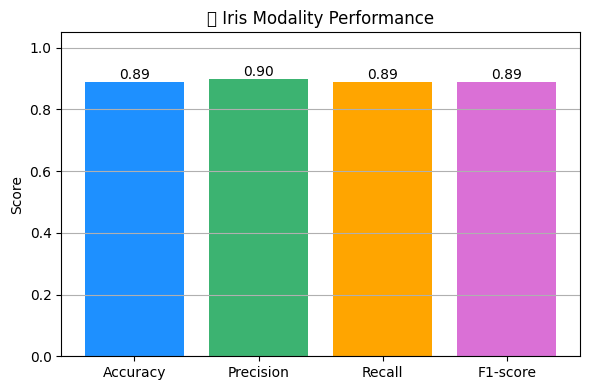

In [19]:
# === IRIS ===
y_iris_true = iris_data["y_val"]
y_iris_pred = iris_model.predict(iris_data["X_val"])
iris_report = classification_report(y_iris_true, y_iris_pred, output_dict=True)
iris_accuracy = accuracy_score(y_iris_true, y_iris_pred)

metrics_iris = {
    "Accuracy": iris_accuracy,
    "Precision": iris_report["weighted avg"]["precision"],
    "Recall": iris_report["weighted avg"]["recall"],
    "F1-score": iris_report["weighted avg"]["f1-score"]
}

colors = ["dodgerblue", "mediumseagreen", "orange", "orchid"]

plt.figure(figsize=(6, 4))
bars = plt.bar(metrics_iris.keys(), metrics_iris.values(), color=colors)
plt.ylim(0.0, 1.05)
plt.title("🟢 Iris Modality Performance")
plt.ylabel("Score")
plt.grid(True, axis='y')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.2f}", ha='center')

plt.tight_layout()
plt.show()


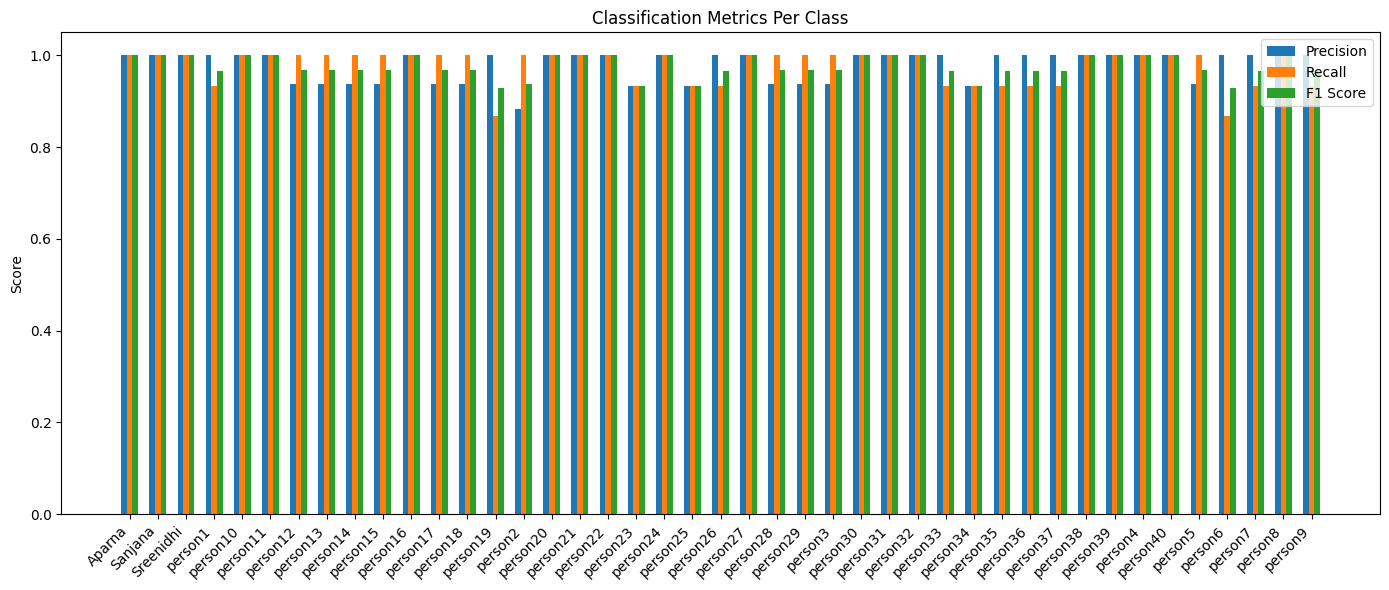

In [22]:
from sklearn.metrics import classification_report

# Get classification report as a dict
report_dict = classification_report(y_val_enc, pred_rf, target_names=encoder.classes_, output_dict=True)

# Extract metrics per class
classes = list(encoder.classes_)
precision = [report_dict[cls]['precision'] for cls in classes]
recall = [report_dict[cls]['recall'] for cls in classes]
f1_score = [report_dict[cls]['f1-score'] for cls in classes]
accuracy = [report_dict[cls]['f1-score'] for cls in classes]  # f1 as per-class performance proxy

# Plotting the metrics
x = np.arange(len(classes))  # class indices
width = 0.2  # width of the bars

plt.figure(figsize=(14, 6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1_score, width, label='F1 Score')

plt.xticks(x, classes, rotation=45, ha='right')
plt.ylabel('Score')
plt.title('Classification Metrics Per Class')
plt.legend()
plt.tight_layout()
plt.show()


# Fingerprint

<h4>Import Required Libraries</h4>

In [23]:
# Step 1: Import required libraries
import os
import glob
import cv2
import numpy as np
import pywt
from tqdm import tqdm
import joblib
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

<h4>Loading Image Paths And Labels</h4>

In [24]:
#Step 2: Load image paths and labels from folder structure
def load_image_paths_and_labels(root_dir):
    image_paths, labels = [], []
    for person_folder in sorted(os.listdir(root_dir)):
        person_path = os.path.join(root_dir, person_folder)
        if os.path.isdir(person_path):
            images = glob.glob(os.path.join(person_path, '*.jpg'))  # or .png
            image_paths.extend(images)
            labels.extend([person_folder] * len(images))
    return image_paths, labels

<h4>Applying CNN Model For Feature Extraction</h4>

In [25]:
# Step 3: Define CNN model for feature extraction
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 256)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (B, 16, 112, 112)
        x = self.pool(F.relu(self.conv2(x)))  # (B, 32, 56, 56)
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))  # (B, 256)
        return x

<h4>Preprocessing And Feature Extraction</h4>

In [26]:
# Step 4: Preprocessing and feature extraction functions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = SimpleCNN().to(device)
cnn_model.eval()

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

def wavelet_transform(image):
    coeffs = pywt.wavedec2(image, 'haar', level=2)
    flattened = []
    for coeff in coeffs:
        if isinstance(coeff, tuple):
            for arr in coeff:
                flattened.extend(arr.flatten())
        else:
            flattened.extend(coeff.flatten())
    return np.array(flattened[:2048])  # Fixed length vector

def preprocess_image_cnn_wtn(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    image_resized = cv2.resize(image, (224, 224))

    # Wavelet features
    wtn_feat = wavelet_transform(image_resized)

    # CNN features
    input_tensor = transform(image_resized).unsqueeze(0).to(device)
    with torch.no_grad():
        cnn_feat = cnn_model(input_tensor).cpu().numpy().flatten()

    # Combine both features
    combined_feat = np.concatenate((wtn_feat, cnn_feat))
    return combined_feat

def preprocess_dataset(image_paths, labels):
    X, y = [], []
    for path, label in tqdm(zip(image_paths, labels), total=len(image_paths), desc="Extracting Features (CNN+WTN)"):
        features = preprocess_image_cnn_wtn(path)
        if features is not None:
            X.append(features)
            y.append(label)
    return X, y

<h4>Loading Datasets</h4>

In [27]:
# Step 5: Load datasets
base_path = r"C:\Users\rames\OneDrive\Desktop\Biometrics\data\fingerprint"
train_images, train_labels = load_image_paths_and_labels(os.path.join(base_path, 'Train'))
test_images, test_labels = load_image_paths_and_labels(os.path.join(base_path, 'Test'))
val_images, val_labels = load_image_paths_and_labels(os.path.join(base_path, 'Validation'))

<h4>Preprocessing Datasets</h4>

In [28]:
# Step 6: Preprocess all datasets
print("Preprocessing training data...")
X_train, y_train = preprocess_dataset(train_images, train_labels)

print("Preprocessing test data...")
X_test, y_test = preprocess_dataset(test_images, test_labels)

print("Preprocessing validation data...")
X_val, y_val = preprocess_dataset(val_images, val_labels)

Preprocessing training data...


Extracting Features (CNN+WTN): 100%|███████████████████████████████████████████████| 3010/3010 [21:55<00:00,  2.29it/s]


Preprocessing test data...


Extracting Features (CNN+WTN): 100%|█████████████████████████████████████████████████| 645/645 [00:31<00:00, 20.19it/s]


Preprocessing validation data...


Extracting Features (CNN+WTN): 100%|█████████████████████████████████████████████████| 645/645 [00:32<00:00, 19.99it/s]


<h4>Encoding Labels</h4>

In [29]:
# Step 7: Encode labels
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)
y_val_enc = encoder.transform(y_val)

<h4>Training Random Forest Classifier</h4>

In [30]:
# Step 8: Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train_enc)

RandomForestClassifier(random_state=42)

<h4>Evaluation , Saving Model And Saving Features Labels</h4>


Random Forest Evaluation on Validation Set:
              precision    recall  f1-score   support

      Aparna       1.00      1.00      1.00        15
     Sanjana       0.88      1.00      0.94        15
   Sreenidhi       1.00      1.00      1.00        15
     person1       1.00      0.73      0.85        15
    person10       0.80      0.80      0.80        15
    person11       0.71      0.80      0.75        15
    person12       0.67      0.67      0.67        15
    person13       0.90      0.60      0.72        15
    person14       0.86      0.80      0.83        15
    person15       0.80      0.80      0.80        15
    person16       0.83      1.00      0.91        15
    person17       0.79      0.73      0.76        15
    person18       0.69      0.73      0.71        15
    person19       0.93      0.93      0.93        15
     person2       0.80      0.80      0.80        15
    person20       0.69      0.60      0.64        15
    person21       0.78      0.93   

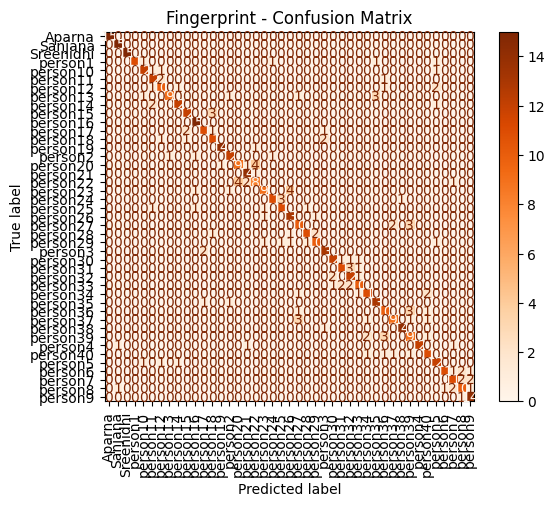


Model saved to random_forest_fingerprint_model_cnn_wtn.pkl
Features and labels saved to fingerprint_features_cnn_wtn.pkl


In [31]:
# Step 9: Evaluate on validation set
print("\nRandom Forest Evaluation on Validation Set:")
pred_val = rf_model.predict(X_val)
print(classification_report(y_val_enc, pred_val, target_names=encoder.classes_))
# Confusion matrix for Fingerprint
cm_fingerprint = confusion_matrix(y_val_enc, pred_val)
disp_fingerprint = ConfusionMatrixDisplay(confusion_matrix=cm_fingerprint, display_labels=encoder.classes_)
disp_fingerprint.plot(cmap='Oranges', xticks_rotation=90)
plt.title("Fingerprint - Confusion Matrix")
plt.show()
# Step 10: Save trained model
model_path = "random_forest_fingerprint_model_cnn_wtn.pkl"
joblib.dump(rf_model, model_path)
print(f"\nModel saved to {model_path}")

# Step 11: Save extracted features and labels
feature_data = {
    "X_train": X_train,
    "y_train": y_train_enc,
    "X_test": X_test,
    "y_test": y_test_enc,
    "X_val": X_val,
    "y_val": y_val_enc,
    "label_encoder": encoder
}

features_path = "fingerprint_features_cnn_wtn.pkl"
with open(features_path, 'wb') as f:
    pickle.dump(feature_data, f)

print(f"Features and labels saved to {features_path}")

<h4> Fingerprint Performance</h4>

C:\Users\rames\AppData\Local\Temp\ipykernel_33156\1253897415.py:27: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rames\anaconda3\envs\Biometrics\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


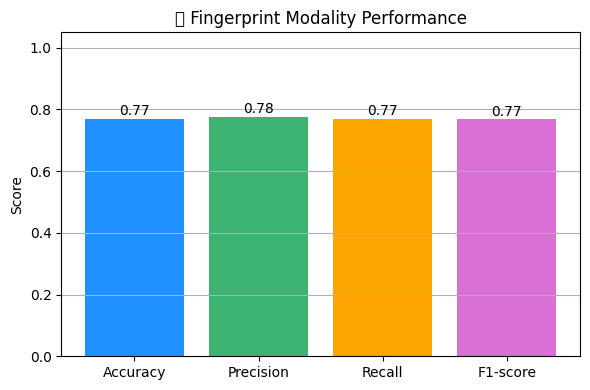

In [15]:
# === FINGERPRINT ===
y_fp_true = fingerprint_data["y_val"]
y_fp_pred = fingerprint_model.predict(fingerprint_data["X_val"])
fp_report = classification_report(y_fp_true, y_fp_pred, output_dict=True)
fp_accuracy = accuracy_score(y_fp_true, y_fp_pred)

metrics_fp = {
    "Accuracy": fp_accuracy,
    "Precision": fp_report["weighted avg"]["precision"],
    "Recall": fp_report["weighted avg"]["recall"],
    "F1-score": fp_report["weighted avg"]["f1-score"]
}

colors = ["dodgerblue", "mediumseagreen", "orange", "orchid"]

plt.figure(figsize=(6, 4))
bars = plt.bar(metrics_fp.keys(), metrics_fp.values(), color=colors)
plt.ylim(0.0, 1.05)
plt.title("🟠 Fingerprint Modality Performance")
plt.ylabel("Score")
plt.grid(True, axis='y')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.2f}", ha='center')

plt.tight_layout()
plt.show()


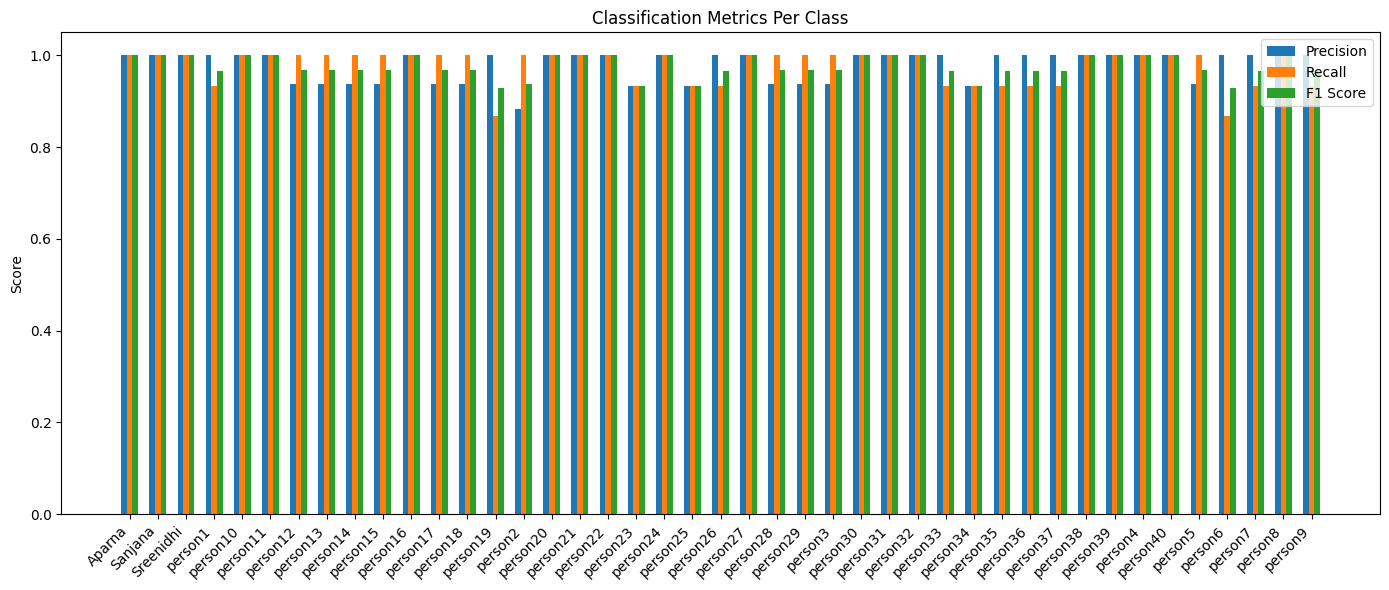

In [32]:
from sklearn.metrics import classification_report

# Get classification report as a dict
report_dict = classification_report(y_val_enc, pred_rf, target_names=encoder.classes_, output_dict=True)

# Extract metrics per class
classes = list(encoder.classes_)
precision = [report_dict[cls]['precision'] for cls in classes]
recall = [report_dict[cls]['recall'] for cls in classes]
f1_score = [report_dict[cls]['f1-score'] for cls in classes]
accuracy = [report_dict[cls]['f1-score'] for cls in classes]  # f1 as per-class performance proxy

# Plotting the metrics
x = np.arange(len(classes))  # class indices
width = 0.2  # width of the bars

plt.figure(figsize=(14, 6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1_score, width, label='F1 Score')

plt.xticks(x, classes, rotation=45, ha='right')
plt.ylabel('Score')
plt.title('Classification Metrics Per Class')
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
### PERFORMANCE METRICS OF ALL MODALITIES
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# === FACE ===
y_face_true = face_data["y_val"]
y_face_pred = face_model.predict(face_data["X_val"])
face_report = classification_report(y_face_true, y_face_pred, output_dict=True)
face_accuracy = accuracy_score(y_face_true, y_face_pred)

# === IRIS ===
y_iris_true = iris_data["y_val"]
y_iris_pred = iris_model.predict(iris_data["X_val"])
iris_report = classification_report(y_iris_true, y_iris_pred, output_dict=True)
iris_accuracy = accuracy_score(y_iris_true, y_iris_pred)

# === FINGERPRINT ===
y_fp_true = fingerprint_data["y_val"]
y_fp_pred = fingerprint_model.predict(fingerprint_data["X_val"])
fp_report = classification_report(y_fp_true, y_fp_pred, output_dict=True)
fp_accuracy = accuracy_score(y_fp_true, y_fp_pred)


In [17]:
modalities = ["Face", "Iris", "Fingerprint"]
accuracy = [face_accuracy, iris_accuracy, fp_accuracy]
precision = [face_report["weighted avg"]["precision"], iris_report["weighted avg"]["precision"], fp_report["weighted avg"]["precision"]]
recall = [face_report["weighted avg"]["recall"], iris_report["weighted avg"]["recall"], fp_report["weighted avg"]["recall"]]
f1 = [face_report["weighted avg"]["f1-score"], iris_report["weighted avg"]["f1-score"], fp_report["weighted avg"]["f1-score"]]


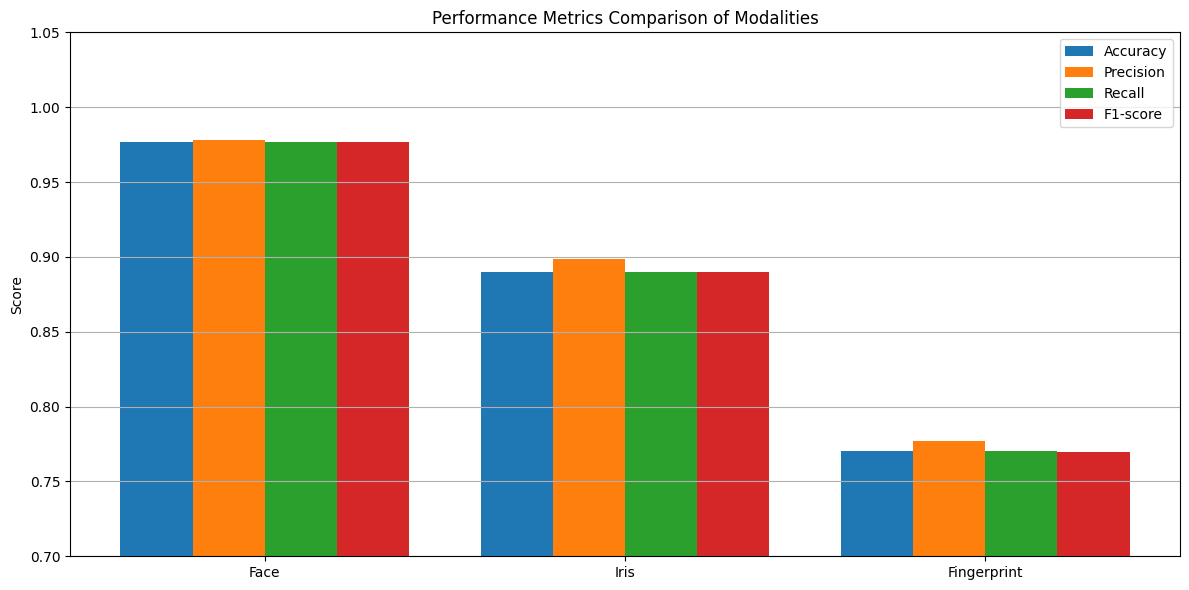

In [18]:
x = np.arange(len(modalities))  # [0, 1, 2]
width = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - 1.5*width, accuracy, width, label="Accuracy")
plt.bar(x - 0.5*width, precision, width, label="Precision")
plt.bar(x + 0.5*width, recall, width, label="Recall")
plt.bar(x + 1.5*width, f1, width, label="F1-score")

plt.xticks(x, modalities)
plt.ylim(0.7, 1.05)
plt.ylabel("Score")
plt.title("Performance Metrics Comparison of Modalities")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


# Score - Level Fusion

In [33]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pickle
import joblib

# === Load pretrained models ===
face_model = joblib.load(r"C:\Users\rames\OneDrive\Desktop\Biometrics\code\random_forest_face_model.pkl")
iris_model = joblib.load(r"C:\Users\rames\OneDrive\Desktop\Biometrics\code\rf_iris_model_wtn_vit.pkl")
fingerprint_model = joblib.load(r"C:\Users\rames\OneDrive\Desktop\Biometrics\code\random_forest_fingerprint_model_cnn_wtn.pkl")

# === Load validation features and labels ===
with open(r"C:\Users\rames\OneDrive\Desktop\Biometrics\code\face_features_and_labels.pkl", "rb") as f:
    face_data = pickle.load(f)
with open(r"C:\Users\rames\OneDrive\Desktop\Biometrics\code\iris_features_wtn_vit.pkl", "rb") as f:
    iris_data = pickle.load(f)
with open(r"C:\Users\rames\OneDrive\Desktop\Biometrics\code\fingerprint_features_cnn_wtn.pkl", "rb") as f:
    fingerprint_data = pickle.load(f)

# Extract features and labels
X_val_face, y_val = face_data["X_val"], face_data["y_val"]
X_val_iris = iris_data["X_val"]
X_val_fingerprint = fingerprint_data["X_val"]
label_encoder = face_data["label_encoder"]

# === Predict probabilities for each modality ===
probs_face = face_model.predict_proba(X_val_face)
probs_iris = iris_model.predict_proba(X_val_iris)
probs_fingerprint = fingerprint_model.predict_proba(X_val_fingerprint)

# === Predict class labels from individual models ===
pred_face = np.argmax(probs_face, axis=1)
pred_iris = np.argmax(probs_iris, axis=1)
pred_fingerprint = np.argmax(probs_fingerprint, axis=1)

# === Calculate accuracy of each model ===
acc_face = accuracy_score(y_val, pred_face)
acc_iris = accuracy_score(y_val, pred_iris)
acc_fingerprint = accuracy_score(y_val, pred_fingerprint)

print("Validation Accuracies:")
print(f"Face Model       : {acc_face:.4f}")
print(f"Iris Model       : {acc_iris:.4f}")
print(f"Fingerprint Model: {acc_fingerprint:.4f}")

# === Normalize accuracies to get weights ===
total_acc = acc_face + acc_iris + acc_fingerprint
w_face = acc_face / total_acc
w_iris = acc_iris / total_acc
w_fingerprint = acc_fingerprint / total_acc

print("\nComputed Weights (Score-Level Fusion):")
print(f"Face Weight       : {w_face:.2f}")
print(f"Iris Weight       : {w_iris:.2f}")
print(f"Fingerprint Weight: {w_fingerprint:.2f}")

# === Score-level fusion using weighted sum rule ===
fused_probs = (w_face * probs_face) + (w_iris * probs_iris) + (w_fingerprint * probs_fingerprint)
final_preds = np.argmax(fused_probs, axis=1)

# === Final Evaluation ===
print("\nMultimodal Fusion Evaluation (Validation Set):")
print(classification_report(y_val, final_preds, target_names=label_encoder.classes_))

Validation Accuracies:
Face Model       : 0.9767
Iris Model       : 0.8899
Fingerprint Model: 0.7705

Computed Weights (Score-Level Fusion):
Face Weight       : 0.37
Iris Weight       : 0.34
Fingerprint Weight: 0.29

Multimodal Fusion Evaluation (Validation Set):
              precision    recall  f1-score   support

      Aparna       1.00      1.00      1.00        15
     Sanjana       1.00      1.00      1.00        15
   Sreenidhi       1.00      1.00      1.00        15
     person1       1.00      1.00      1.00        15
    person10       1.00      1.00      1.00        15
    person11       1.00      1.00      1.00        15
    person12       1.00      1.00      1.00        15
    person13       1.00      1.00      1.00        15
    person14       1.00      1.00      1.00        15
    person15       1.00      1.00      1.00        15
    person16       1.00      1.00      1.00        15
    person17       1.00      1.00      1.00        15
    person18       1.00      1.00

<h5> ROC Curve and MCC Score </h5>

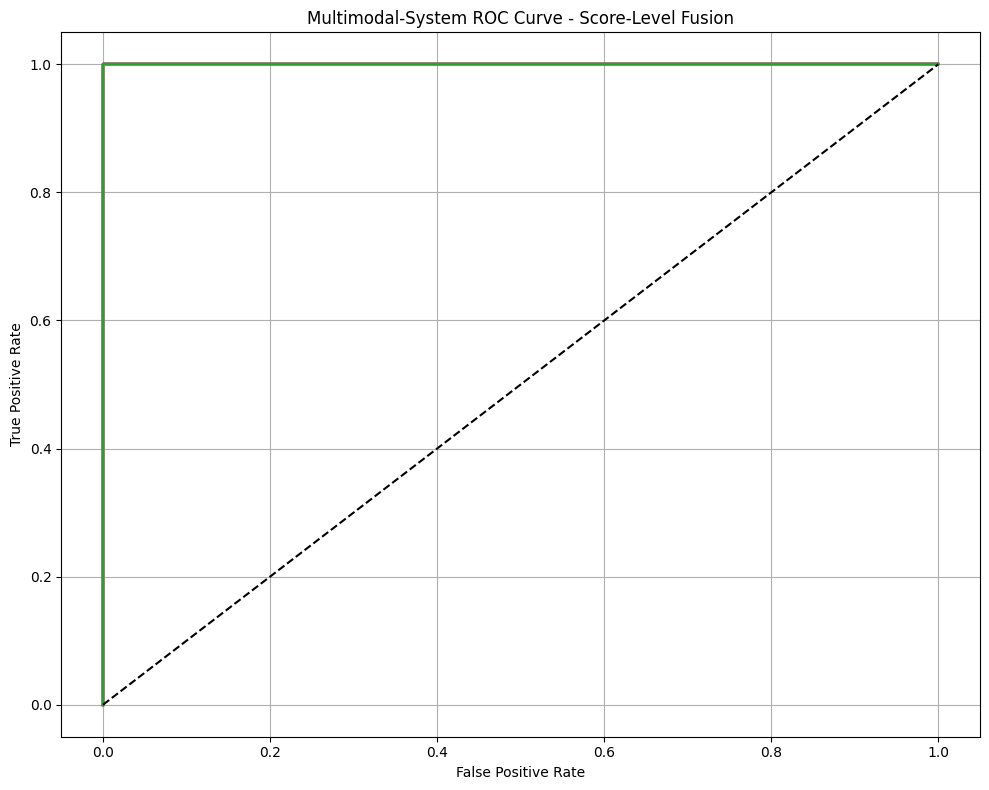

🧠 MCC Score (Fusion Output): 1.0


In [3]:
###ROC CURVE FOR MULTIMODAL
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, matthews_corrcoef
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import pickle
import joblib

# === Load models ===
face_model = joblib.load("random_forest_face_model.pkl")
iris_model = joblib.load("rf_iris_model_wtn_vit.pkl")
fingerprint_model = joblib.load("random_forest_fingerprint_model_cnn_wtn.pkl")

# === Load feature sets ===
with open("face_features_and_labels.pkl", "rb") as f:
    face_data = pickle.load(f)
with open("iris_features_wtn_vit.pkl", "rb") as f:
    iris_data = pickle.load(f)
with open("fingerprint_features_cnn_wtn.pkl", "rb") as f:
    fingerprint_data = pickle.load(f)

X_val_face = face_data["X_val"]
X_val_iris = iris_data["X_val"]
X_val_fingerprint = fingerprint_data["X_val"]
y_val = face_data["y_val"]
label_encoder = face_data["label_encoder"]

# === Get prediction probabilities ===
probs_face = face_model.predict_proba(X_val_face)
probs_iris = iris_model.predict_proba(X_val_iris)
probs_fingerprint = fingerprint_model.predict_proba(X_val_fingerprint)

# === Compute validation accuracy for each ===
acc_face = accuracy_score(y_val, np.argmax(probs_face, axis=1))
acc_iris = accuracy_score(y_val, np.argmax(probs_iris, axis=1))
acc_fingerprint = accuracy_score(y_val, np.argmax(probs_fingerprint, axis=1))

# === Normalize to weights ===
total_acc = acc_face + acc_iris + acc_fingerprint
w_face = acc_face / total_acc
w_iris = acc_iris / total_acc
w_fingerprint = acc_fingerprint / total_acc

# === Score-level fusion ===
fused_probs = (w_face * probs_face) + (w_iris * probs_iris) + (w_fingerprint * probs_fingerprint)
final_preds = np.argmax(fused_probs, axis=1)

# === ROC Curve ===
y_bin = label_binarize(y_val, classes=np.arange(len(label_encoder.classes_)))
n_classes = y_bin.shape[1]

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], fused_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multimodal-System ROC Curve - Score-Level Fusion")
## plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# === MCC Score ===
mcc = matthews_corrcoef(y_val, final_preds)
print("🧠 MCC Score (Fusion Output):", mcc)


# Comparison between Unimodal and Multimodal Biometrics Graphically

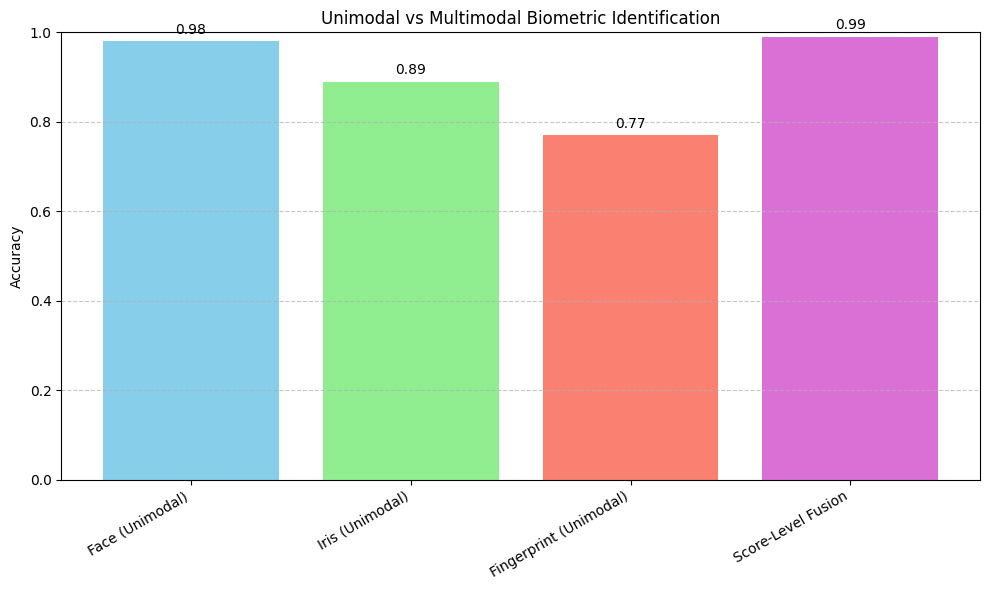

In [1]:
import matplotlib.pyplot as plt

# Replace these with your actual accuracies
acc_face = 0.98
acc_iris = 0.89
acc_fingerprint = 0.77
acc_score_fusion = 0.99

# Labels and values
methods = [
    "Face (Unimodal)",
    "Iris (Unimodal)",
    "Fingerprint (Unimodal)",
    "Score-Level Fusion"
]
accuracies = [
    acc_face,
    acc_iris,
    acc_fingerprint,
    acc_score_fusion
]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, accuracies, color=['skyblue', 'lightgreen', 'salmon', 'orchid'])
plt.ylim(0, 1.0)
plt.ylabel("Accuracy")
plt.title("Unimodal vs Multimodal Biometric Identification")

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


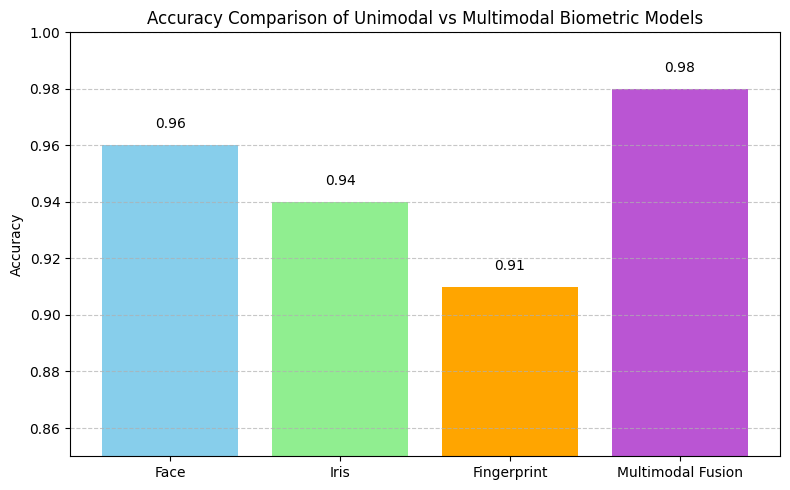

In [1]:
import matplotlib.pyplot as plt

# 🔢 Replace these with your actual accuracy values
acc_face = 0.96
acc_iris = 0.94
acc_fp = 0.91
acc_fusion = 0.98

# 📦 Labels and accuracy values
modalities = ['Face', 'Iris', 'Fingerprint', 'Multimodal Fusion']
accuracies = [acc_face, acc_iris, acc_fp, acc_fusion]
colors = ['skyblue', 'lightgreen', 'orange', 'mediumorchid']

# 📊 Plotting the bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(modalities, accuracies, color=colors)

# 📌 Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.2f}", ha='center', va='bottom')

# 🪄 Formatting
plt.ylim(0.85, 1.0)
plt.title('Accuracy Comparison of Unimodal vs Multimodal Biometric Models')
plt.ylabel('Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
